# Comparison wind and surge data
This notebook compares the performance of some variants of the sea level rise (SLR) regression model. 
- The first variant includes wind data (wind speed and wind direction) as an explanatory variable. Two versions of the model with wind are considered and compared as the original wind decomposition could be improved upon. 
- The second variant corrects the water levels for the (modelled) storm surges. To improve our understanding of the model we consider the correlation between storm surges and water levels (and also the residuals from the regression model without wind) and we add the storm surge as an explanatory variable to the model.

In [1]:
# Standard Python packages
import io

# Python packages that need to be installed using pip or anaconda:
# For computations
import pandas
import numpy as np

# For GIS related function
import pyproj
from shapely.geometry import LineString, Point

# For loading netcdf
import netCDF4

# For plotting
import matplotlib.pyplot as plt
import bokeh.palettes
import bokeh.plotting
from bokeh.models import HoverTool

# Initialize modules for the jupyter notebook format
from nbformat import current
%matplotlib inline
bokeh.io.output_notebook()

from IPython.display import display
import shutil

# Disable pandas warnings
pandas.options.mode.chained_assignment = None

C:\Anaconda3\lib\site-packages\nbformat\current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


Loading BokehJS ...

### Load standard functions

Define function to execute other notebooks.

In [2]:
def execute_notebook(nbfile):
    """Function to run other notebook in this notebook"""
    with io.open(nbfile,encoding="utf8") as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)


In [3]:
execute_notebook('../satellite/get-data.ipynb')

### Get PSMSL RLR annual data
Annual and monthly sea level data are obtained from PSMSL. 
Wind data and storm surge data are obtained from other sources. See for more details '../satellite/get-data.ipynb'.
Below some data formatting is done.

In [4]:
station_names = [
    'Vlissingen', 
    'Hoek van Holland', 
    'Den Helder', 
    'Delfzijl', 
    'Harlingen', 
    'IJmuiden'
]

# The alpha values are the dominant wind direction for the coast stations.
alphas = {
    "delfzijl": 117,
    "harlingen": 108,
    "den helder": 107,
    "ijmuiden": 110,
    "hoek van holland": 117,
    "vlissingen": 118
}

# Wind station at sea is about 50 km from IJmuiden (Locatie wind data is 50 km uit kust vanuit IJmuiden)
rlr_data = get_station_data(dataset_name='rlr_annual', coastline_code=150, names=station_names, alphas=alphas)
rlr_data

found point 52.3799 3.75
rlr_annual 20 rlr
rlr_annual 22 rlr
rlr_annual 23 rlr
rlr_annual 24 rlr
rlr_annual 25 rlr
rlr_annual 32 rlr


,lat,lon,name,coastline_code,station_code,quality,url,data
id,,,,,,,,
20,51.442222,3.596111,VLISSINGEN,150,101,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
22,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
23,52.964444,4.745000,DEN HELDER,150,31,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
24,53.326389,6.933056,DELFZIJL,150,1,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
25,53.175556,5.409444,HARLINGEN,150,21,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
32,52.462222,4.554722,IJMUIDEN,150,41,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...


Code below has been moved to get-data. It specifies the actions required the wind speed components with respect to the angle alpha (dominant wind direction) from the available wind data set. The wind speed is decomposed in two components: main (along the angle) and perp (perpendicular to the coast).

In [5]:
# Overgenomen uit zeespiegelmonitor 2013:
# localfa  <- c("Delfzijl","Harlingen","Den Helder","IJmuiden","Hoek van Holland","Vlissingen","gemiddeld")
# valalfa  <- c(117       ,108        ,107         ,110       ,117               ,118         ,112        )
  
# alphas = {
#     "delfzijl": 117,
#     "harlingen": 108,
#     "den helder": 107,
#     "ijmuiden": 110,
#     "hoek van holland": 117,
#     "vlissingen": 118
# }

# # Direction is gerekend in radialen in carthesisch stelsel. Reken om naar Nautisch
# def car2nau(carthesian):
#     nautical = ((carthesian * -1) + 90) % 360
#     return nautical

# df = rlr_data.loc[20, 'data']

# df['dir_car_deg'] = df['direction'] / np.pi * 180
# df['dir_nau_deg'] = car2nau(dir_car_deg)

# df['U2main'] = df['speed'] ** 2 * np.cos(np.pi / 180 * (dir_nau_deg - alpha['Vlissingen']))
# df['U2perp'] = df['speed'] ** 2 * np.sin(np.pi / 180 * (dir_nau_deg - alpha['Vlissingen']))

# df.tail()

In [6]:
rlr_data.loc[20, 'data'].tail(10)

,year,height,interpolated,flags,station,direction,speed,u,v,u2,v2,u2main,u2perp
t,,,,,,,,,,,,,
2007-01-01,2007,46.0,N,0,20,3.474220,2.954849,2.390828,0.345955,10.395702,2.455987,8.659533,-7.424133
2008-01-01,2008,19.0,N,0,20,0.906970,3.571877,2.186677,1.553167,10.206668,5.924030,5.384502,-11.488453
2009-01-01,2009,1.0,N,0,20,2.665082,2.958833,1.680295,1.128736,5.437866,6.258957,3.217318,-8.836187
2010-01-01,2010,3.0,N,0,20,2.393399,1.758827,0.842527,-0.395506,1.920831,1.914883,2.257880,0.140507
2011-01-01,2011,7.0,N,0,20,1.707437,3.095699,2.143113,1.469787,9.140764,4.383773,6.117858,-10.589936
2012-01-01,2012,0.0,N,0,20,1.994099,2.981646,2.191390,1.284763,6.817776,3.636866,5.070462,-7.926031
2013-01-01,2013,-14.0,N,0,20,3.413254,2.624925,1.037140,0.346735,5.786909,4.661937,1.565173,-4.714862
2014-01-01,2014,24.0,N,0,20,2.433411,3.526154,1.564820,1.863233,5.614649,12.680093,0.746273,-15.027488
2015-01-01,2015,27.0,N,0,20,2.121403,3.524224,2.715002,1.360416,12.419351,6.724552,8.372716,-15.645702


In [7]:
stations = [20, 22, 23, 24, 25, 32]

grouped = pandas.concat(rlr_data.loc[stations, 'data'].tolist())[['year', 'height', 'u', 'v', 'u2', 'v2', 'u2main', 'u2perp']].groupby(['year'])
mean_df = grouped.mean().reset_index()
# filter out non-trusted part (before NAP)
mean_df = mean_df[mean_df['year'] >= 1890]

station_names = [st.capitalize() for st in rlr_data.loc[stations, 'name'].tolist()]

print(f'The sea water level data from the following stations shall be analyzed: {", ".join(station_names)}')

The sea water level data from the following stations shall be analyzed: Vlissingen, Hoek van holland, Den helder, Delfzijl, Harlingen, Ijmuiden


### Fit models

The following models are fitted:
- linear model without wind or surge: 
    sea water level ~ constant + trend + 18,613 nodal cycle (model without wind)
    
- linear model with wind: 
    sea water level ~ constant + trend + 18,613 nodal cycle + wind components squared (model with wind)
    - decomposition of the wind as is in the sea level monitor (South to North is main, West to East is perp 

- linear model with corrected wind: 
    sea water level ~ constant + trend + 18,613 nodal cycle + corrected wind components squared (model with wind)    
    - improved decomposition of the wind as proposed earlier in Baart et al. (2014) - sea level monitor 2013.

- linear model with surge: 
    (sea water level - storm surge) ~ constant + trend + 18,613 nodal cycle (model with storm surge correction)

The linear models with corrected wind and with surge are specified below. The notebook get-data consists of the definition of the linear model with wind and the model without wind.

First we fit the above models, next we analyze the correlation between sea water levels and storm surges. Finally, we fit another variant of the model with correction for surge: 
    sea water level ~ constant + trend + 18,613 nodal cycle + storm surge (model with storm surge)

# @Guus: op den duur kunnen model met surge en model met corrected wind dus ook naar get_data of een ander separaat notebook?

In [8]:
def linear_model_with_corrected_wind(df):
    """
    Return the fit from the linear model on the given dataset df.
    Wind and season can be enabled and disabled
    """
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V']
    
    X = np.c_[
        X,
        df['u2main'],
        df['u2perp']
    ]
    names.extend(['Wind U^2 main', 'Wind U^2 perp'])
    
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop')
    fit = model.fit()
    return fit, names

Fit the four models. 

In [9]:
tables = {}

# first the model without wind
linear_fit, names = linear_model(mean_df, with_wind=False, with_season=False)
tables['without'] = linear_fit.summary(yname='Sea-surface height', xname=names, title='Linear model without (1890-current)')
display(tables['without'])

# and then the model with wind
linear_with_wind_fit, names = linear_model(mean_df, with_wind=True, with_season=False)
tables['with wind'] = linear_with_wind_fit.summary(
    yname='Sea-surface height', 
    xname=names,
    title='Linear model with wind (1948-current)'
)
display(tables['with wind'])

# and then the model with wind
linear_with_corrected_wind_fit, names = linear_model_with_corrected_wind(mean_df)
tables['with corrected wind'] = linear_with_corrected_wind_fit.summary(
    yname='Sea-surface height', 
    xname=names,
    title='Linear model with corrected wind (1948-current)'
)
display(tables['with corrected wind'])

# if (linear_fit.aic < linear_with_wind_fit.aic):
#     print('The linear model without wind is a higher quality model (smaller AIC) than the linear model with wind.')
# else:
#     print('The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.')

# Load surge and convert from meters to mm
# File surge.pkl (~ 100 MB) is saved in a local local folder)
# surge = pandas.read_pickle('d:/Documents/2695.50 Zeespiegelstijging 2018/Data/surge.pkl') * 1000
surge = pandas.read_pickle('d:/Documents/2695.50 Zeespiegelstijging 2018/Data/surge.pkl') * 1000

# Calculate average over given stations, per year
average = surge[station_names].groupby(surge.index.year).mean().mean(axis=1)

# Construct dataframe and add to mean_df
surge_per_year = pandas.DataFrame(data=[average.mean()] * len(mean_df), index=mean_df['year'], columns=['surge'])
surge_per_year.loc[average.index, 'surge'] = average.values
surge_per_year.index.name = 'year'
if 'surge' not in mean_df.columns:
    mean_df = mean_df.merge(surge_per_year.reset_index(), on='year')

mean_df.head()

mean_df_corrected = mean_df.copy()
mean_df_corrected['height'] -= mean_df_corrected['surge']

linear_fit_corrected, names = linear_model(mean_df_corrected, with_wind=False, with_season=False)
table = linear_fit_corrected.summary(
    yname='Sea-surface height', 
    xname=names,
    title='Linear model corrected for surge (1979-current)'
)
display(table)

print(f'Linear model without wind or surge (1890-current): AIC = {linear_fit.aic}')
print(f'Linear model with wind (1948-current): AIC = {linear_with_wind_fit.aic}')
print(f'Linear model with corrected wind (1948-current): AIC = {linear_with_corrected_wind_fit.aic}')
print(f'Linear model corrected for surge (1979-current): AIC = {linear_fit_corrected.aic}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Linear model without (1890-current)                      
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     243.9
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           1.38e-51
Time:                        11:25:58   Log-Likelihood:                -605.86
No. Observations:                 127   AIC:                             1220.
Df Residuals:                     123   BIC:                             1231.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -24.7060      2.841     -8.695      0.000     -30.330     -19.082
Trend          1.9072      0.071     27.028      0.000       1.768       2.047
Nodal U        5.9075      3.666      1.612      0.110      -1.348      13.163
Nodal V      -12.1065      3.637     -3.329      0.001     -19.305      -4.908
==============================================================================
Omnibus:                        3.424   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                3.115
Skew:                          -0.382   Prob(JB):                        0.211
Kurtosis:                       3.061   Cond. No.                         57.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with wind (1948-current)                     
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     183.6
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           9.63e-55
Time:                        11:25:58   Log-Likelihood:                -592.41
No. Observations:                 127   AIC:                             1197.
Df Residuals:                     121   BIC:                             1214.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -69.0715      9.850     -7.013      0.000     -88.571     -49.572
Trend          1.8757      0.064     29.103      0.000       1.748       2.003
Nodal U        5.3673      3.329      1.612      0.110      -1.224      11.958
Nodal V      -11.5708      3.311     -3.495      0.001     -18.125      -5.016
Wind U^2       6.0411      1.174      5.146      0.000       3.717       8.365
Wind V^2      -0.0600      1.591     -0.038      0.970      -3.209       3.089
==============================================================================
Omnibus:                        8.235   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.372
Skew:                          -0.493   Prob(JB):                       0.0152
Kurtosis:                       3.781   Cond. No.                         172.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
               Linear model with corrected wind (1948-current)                
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     239.1
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           6.10e-61
Time:                        11:25:59   Log-Likelihood:                -577.39
No. Observations:                 127   AIC:                             1167.
Df Residuals:                     121   BIC:                             1184.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant        -71.1360      6.224    -11.428      0.000     -83.459     -58.813
Trend             1.8661      0.058     32.357      0.000       1.752       1.980
Nodal U           3.6259      2.969      1.221      0.224      -2.252       9.504
Nodal V         -11.5695      2.932     -3.946      0.000     -17.374      -5.765
Wind U^2 main     6.9232      1.118      6.193      0.000       4.710       9.136
Wind U^2 perp    -1.4169      0.896     -1.582      0.116      -3.190       0.357
==============================================================================
Omnibus:                        1.828   Durbin-Watson:                   1.519
Prob(Omnibus):                  0.401   Jarque-Bera (JB):                1.374
Skew:                          -0.122   Prob(JB):                        0.503
Kurtosis:                       3.447   Cond. No.                         122.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
               Linear model corrected for surge (1979-current)                
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     322.9
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           4.08e-58
Time:                        11:25:59   Log-Likelihood:                -588.10
No. Observations:                 127   AIC:                             1184.
Df Residuals:                     123   BIC:                             1196.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.7182      2.471     -9.600      0.000     -28.609     -18.828
Trend          1.9091      0.061     31.115      0.000       1.788       2.031
Nodal U        5.1891      3.187      1.628      0.106      -1.120      11.498
Nodal V      -10.4890      3.162     -3.317      0.001     -16.749      -4.229
==============================================================================
Omnibus:                        3.340   Durbin-Watson:                   1.534
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                2.807
Skew:                          -0.280   Prob(JB):                        0.246
Kurtosis:                       3.465   Cond. No.                         57.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Linear model without wind or surge (1890-current): AIC = 1219.7180419590743
Linear model with wind (1948-current): AIC = 1196.8226390701186
Linear model with corrected wind (1948-current): AIC = 1166.7800951254076
Linear model corrected for surge (1979-current): AIC = 1184.205592241473


The first three linear models are fitted to the same sea level data and so we may compare the AIC values. In the fourth model  the annual average sea level is corrected for the storm surge (model outcomes are subtracted from the sea levels). Hence, we cannot compare the AIC values of this model with the other models.

Note that the surge data are available from 1979 onwards and the wind data are available from 1948 onwards. For the years where storm surge or wind data are missing mean values are used in the linear regressions.

The lower the AIC, the better the model performance. 
- The linear model with wind (the current sea leve monitor SLR model) outperforms the model without wind on the same dataset.
- The linear model with the corrected wind performs even better than the model with the 'original' wind.

In the linear model corrected for surge the annual average sea level is corrected for the storm surge from storm surge model outcomes. This approach implicitly assumes the model surge output to be match perfectly with sea water levels and hence can be subtracted from the sea level. We shall assess the correlation between surge and sea water levels below. Further analyses on the storm surges from the global tidal surge reanalysis (GTSR) model can be found in '\Analyse_GTSR.ipynb'.

In [10]:
print(f'Average surge for ({", ".join(station_names)}) = {surge[station_names].mean().mean()} mm')

Average surge for (Vlissingen, Hoek van holland, Den helder, Delfzijl, Harlingen, Ijmuiden) = -0.9473910066790093 mm


In [11]:
# plot the model with wind. 
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)

fig.circle(
    mean_df.year,
    mean_df.height,
    line_width=1,
    legend='Annual mean sea level (data)',
    color='black',
    alpha=0.5
)

fig.line(
    linear_fit.model.exog[:, 1] + 1970, 
    linear_fit.predict(), 
    line_width=3, 
    legend='Current sea level (linear model without wind)', 
    color='green',
    alpha=0.5
)

fig.line(
    linear_with_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_wind_fit.predict(), 
    line_width=3, 
    alpha=0.5,
    #color='blue',
    legend='Current sea level (linear model with wind)'
)

fig.line(
    linear_with_corrected_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_corrected_wind_fit.predict(), 
    line_width=3, 
    alpha=0.5,
    legend='Current sea level (linear model with corrected wind)',
    color='purple'
)


fig.circle(
    mean_df_corrected.year[mean_df_corrected.year >= 1979],
    mean_df_corrected.height[mean_df_corrected.year >= 1979],
    line_width=1,
    legend='Annual mean sea level corrected for storm surge (data)',
    color='orange',
    alpha=0.5
)

fig.line(
    linear_fit_corrected.model.exog[:, 1] + 1970, 
    linear_fit_corrected.predict(), 
    line_width=3, 
    legend='Current sea level minus storm surge (linear model)', 
    color='red',
    line_dash='dashed',
    alpha=0.5
)

fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above NAP'
fig.xaxis.axis_label = 'year'
#fig.legend.click_policy = "hide"

bokeh.io.show(fig)

The graph shows the annual sea levels and the fit of the linear model (without and with wind). Also, the graph shows the annual sea level minus the storm surge and the corresponding fit of the linear model.
Both the wind as well as the storm surge seem to explain the yearly variation in the sea level quite well. 

We now add the modelled surge as an exploratory variable to the linear model (in stead of the wind) and estimate the regression coefficient. One would expect a coefficient close to 1 (hypothesis). 
N.B. The years prior to 1979 are disregarded.

Let us now first determine the correlation between the storm surge and the residuals of the regression model without wind.

0.735141273744


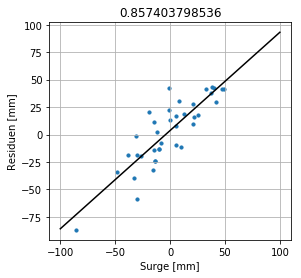

In [12]:
yearmin = 1979
indices = mean_df['year'] >= yearmin
#print(indices)

fig, ax = plt.subplots()

xdata = mean_df.loc[indices, 'surge'].values
#print(mean_df.loc[indices, 'surge'])
#print(xdata, len(xdata))

# @ GUUS: deze regel werkt bij mij niet naar behoren
#ydata = linear_fit.resid.values[indices] 
ydata = linear_fit.resid.tail(len(xdata)).values

#print(linear_fit.resid)
#print(linear_fit.resid.values)
#print(linear_fit.resid.tail(len(xdata)).values)
#ydata = linear_fit.resid.tail(len(xdata)).values
#print(ydata, len(ydata))

ax.scatter(xdata, ydata, s=10)
ax.grid()
ax.set_ylabel('Residuen [mm]')
ax.set_xlabel('Surge [mm]')
ax.set_aspect(1.0)

x = np.linspace(-100, 100, 100)
p = np.polyfit(xdata, ydata, 1)
y = np.polyval(p, x)
ax.plot(x, y, color='k')

ax.set_title(np.corrcoef(xdata, ydata)[0, 1])
print(np.square(np.corrcoef(xdata, ydata)[0, 1]))

The correlation coefficient is about 0.86 and so the storm surge explains about 73% of the variation in the residuals.

Next we compare the annual sea level to the annual storm surge.

0.46436602321


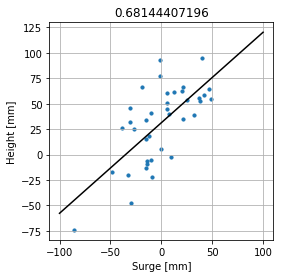

In [13]:
yearmin = 1979
indices = mean_df['year'] >= yearmin

fig, ax = plt.subplots()

ax.scatter(mean_df.loc[indices, 'surge'].values, mean_df.loc[indices, 'height'].values, s=10)
ax.grid()
ax.set_xlabel('Surge [mm]')
ax.set_ylabel('Height [mm]')
ax.set_aspect(1.0)

x = np.linspace(-100, 100, 100)
p = np.polyfit(mean_df.loc[indices, 'surge'].values, mean_df.loc[indices, 'height'].values, 1)
y = np.polyval(p, x)
ax.plot(x, y, color='k')

ax.set_title(np.corrcoef(mean_df.loc[indices, 'surge'].values, mean_df.loc[indices, 'height'].values)[0, 1])
print(np.square(np.corrcoef(mean_df.loc[indices, 'surge'].values, mean_df.loc[indices, 'height'].values)[0, 1]))

Again, we find that a large part of the variation in the annual sea level can be explained by the yearly variation in storm surge. Hence, we define a linear model with the (modelled) storm surge as an explanatory variable. That is, 

sea water level ~ constant + trend + 18,613 nodal cycle + storm surge (model with storm surge)

In [14]:
def linear_model_with_surge(df):
    """
    Return the fit from the linear model on the given dataset df.
    Wind and season can be enabled and disabled
    """
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613),
        df['surge']# * (df['year'] >= 1979)    
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V', 'Surge']
        
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop')
    fit = model.fit()
    return fit, names

In [15]:
linear_fit_with_surge, names = linear_model_with_surge(mean_df)
tables['with surge'] = linear_fit_with_surge.summary(
    yname='Sea-surface height', 
    xname=names, 
    title='Linear model with surge (1979-current)'
)

In [16]:
display(tables['without'])
display(tables['with wind'])
display(tables['with corrected wind'])
display(tables['with surge'])

print(f'Linear model without wind or surge (1890-current): AIC = {linear_fit.aic}')
print(f'Linear model with wind (1948-current): AIC = {linear_with_wind_fit.aic}')
print(f'Linear model with corrected wind (1948-current): AIC = {linear_with_corrected_wind_fit.aic}')
print(f'Linear model with surge (1979-current): AIC = {linear_fit_with_surge.aic}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Linear model without (1890-current)                      
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     243.9
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           1.38e-51
Time:                        11:25:58   Log-Likelihood:                -605.86
No. Observations:                 127   AIC:                             1220.
Df Residuals:                     123   BIC:                             1231.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -24.7060      2.841     -8.695      0.000     -30.330     -19.082
Trend          1.9072      0.071     27.028      0.000       1.768       2.047
Nodal U        5.9075      3.666      1.612      0.110      -1.348      13.163
Nodal V      -12.1065      3.637     -3.329      0.001     -19.305      -4.908
==============================================================================
Omnibus:                        3.424   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                3.115
Skew:                          -0.382   Prob(JB):                        0.211
Kurtosis:                       3.061   Cond. No.                         57.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with wind (1948-current)                     
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     183.6
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           9.63e-55
Time:                        11:25:58   Log-Likelihood:                -592.41
No. Observations:                 127   AIC:                             1197.
Df Residuals:                     121   BIC:                             1214.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -69.0715      9.850     -7.013      0.000     -88.571     -49.572
Trend          1.8757      0.064     29.103      0.000       1.748       2.003
Nodal U        5.3673      3.329      1.612      0.110      -1.224      11.958
Nodal V      -11.5708      3.311     -3.495      0.001     -18.125      -5.016
Wind U^2       6.0411      1.174      5.146      0.000       3.717       8.365
Wind V^2      -0.0600      1.591     -0.038      0.970      -3.209       3.089
==============================================================================
Omnibus:                        8.235   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.372
Skew:                          -0.493   Prob(JB):                       0.0152
Kurtosis:                       3.781   Cond. No.                         172.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
               Linear model with corrected wind (1948-current)                
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     239.1
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           6.10e-61
Time:                        11:25:59   Log-Likelihood:                -577.39
No. Observations:                 127   AIC:                             1167.
Df Residuals:                     121   BIC:                             1184.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant        -71.1360      6.224    -11.428      0.000     -83.459     -58.813
Trend             1.8661      0.058     32.357      0.000       1.752       1.980
Nodal U           3.6259      2.969      1.221      0.224      -2.252       9.504
Nodal V         -11.5695      2.932     -3.946      0.000     -17.374      -5.765
Wind U^2 main     6.9232      1.118      6.193      0.000       4.710       9.136
Wind U^2 perp    -1.4169      0.896     -1.582      0.116      -3.190       0.357
==============================================================================
Omnibus:                        1.828   Durbin-Watson:                   1.519
Prob(Omnibus):                  0.401   Jarque-Bera (JB):                1.374
Skew:                          -0.122   Prob(JB):                        0.503
Kurtosis:                       3.447   Cond. No.                         122.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with surge (1979-current)                    
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     250.9
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           7.49e-58
Time:                        11:26:00   Log-Likelihood:                -587.85
No. Observations:                 127   AIC:                             1186.
Df Residuals:                     122   BIC:                             1200.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.8161      2.480     -9.604      0.000     -28.725     -18.907
Trend          1.9090      0.061     31.047      0.000       1.787       2.031
Nodal U        5.2603      3.196      1.646      0.102      -1.066      11.586
Nodal V      -10.6493      3.177     -3.352      0.001     -16.939      -4.359
Surge          0.9009      0.142      6.325      0.000       0.619       1.183
==============================================================================
Omnibus:                        3.618   Durbin-Watson:                   1.541
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                3.093
Skew:                          -0.295   Prob(JB):                        0.213
Kurtosis:                       3.486   Cond. No.                         57.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Linear model without wind or surge (1890-current): AIC = 1219.7180419590743
Linear model with wind (1948-current): AIC = 1196.8226390701186
Linear model with corrected wind (1948-current): AIC = 1166.7800951254076
Linear model with surge (1979-current): AIC = 1185.7028881668289


The coefficient of the surge (0.9009) is close to 1. The null hypothesis that is equals 1 cannot be rejected at a significance level of 5%. This means that we can just subtract the storm surge values from the sea water levels.

We can now compare the AIC values of the models with wind and with surge. This comparison is not really fair, because the model with surge uses far more 'average' values than the models with wind. This might be the explanation that the model with corrected wind performs better than the model with surge.

In [17]:
# plot the models again 
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)

fig.circle(
    mean_df.year,
    mean_df.height,
    line_width=1,
    legend='Annual mean sea level (data)',
    color='black',
    alpha=0.5
)

fig.line(
    linear_fit.model.exog[:, 1] + 1970, 
    linear_fit.predict(), 
    line_width=3, 
    legend='Current sea level (linear model without wind)', 
    color='green',
    line_dash='dashed',
    alpha=0.5
)

fig.line(
    linear_with_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_wind_fit.predict(), 
    line_width=3, 
    alpha=0.5,
    legend='Current sea level (linear model with wind)'
)

fig.line(
    linear_with_corrected_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_corrected_wind_fit.predict(), 
    line_width=3, 
    alpha=0.5,
    legend='Current sea level (linear model with corrected wind)',
    color='purple'
)

fig.line(
    linear_fit_with_surge.model.exog[:, 1] + 1970, 
    linear_fit_with_surge.predict(), 
    line_width=3, 
    legend='Current sea level (linear model with surge)', 
    color='red',
    alpha=0.5
)

#fig.circle(
#    mean_df_corrected.year[mean_df_corrected.year >= 1979],
#    mean_df_corrected.height[mean_df_corrected.year >= 1979],
#    line_width=1,
#    legend='Annual sea level corrected for storm surge (data)',
#    color='orange',
#    alpha=0.5
#)

fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above NAP'
fig.xaxis.axis_label = 'year'
#fig.legend.click_policy = "hide"

bokeh.io.show(fig)

The plot shows that the model with (the corrected) wind and the model with storm surge correction both perform quite well in the period 1979-now. As shown before the AIC-value of the model with surge is lower than the AIC-value of the model with wind. The (only) d8fference9between these models is that the number of wind observations is higher than the number of storm surge observations. Note agaibefore the year  me9n values have been used to fill up the wind and storm surge variables before the year 1948 and 1979, respectively. 

To make a fair comparison we define a wind data set with mean values in the same years as the storm surge data set (before the year 1979) and perform a regression on this new wind data set. Next we compare the AIC-value again with that of the model with surge.

In [18]:
df1979 = mean_df.copy()

for col in ['u2', 'v2', 'u2main', 'u2perp']:
    df1979.loc[df1979['year'] < 1979, col] = df1979.at[0, col]
    
display(df1979.loc[80:100])

,year,height,u,v,u2,v2,u2main,u2perp,surge
80,1970,-9.833333,2.061359,0.284011,7.298842,4.302146,5.385845,-5.988646,-0.960549
81,1971,-60.166667,1.054971,-0.074425,7.298842,4.302146,5.385845,-5.988646,-0.960549
82,1972,-88.333333,0.580966,0.754282,7.298842,4.302146,5.385845,-5.988646,-0.960549
83,1973,-20.500000,2.287425,-0.576052,7.298842,4.302146,5.385845,-5.988646,-0.960549
84,1974,-16.666667,2.115610,0.586363,7.298842,4.302146,5.385845,-5.988646,-0.960549
85,1975,-52.000000,1.162257,-0.147585,7.298842,4.302146,5.385845,-5.988646,-0.960549
86,1976,-75.500000,0.709032,-0.120357,7.298842,4.302146,5.385845,-5.988646,-0.960549
87,1977,-24.166667,1.855726,0.693890,7.298842,4.302146,5.385845,-5.988646,-0.960549
88,1978,-31.833333,1.814568,0.416200,7.298842,4.302146,5.385845,-5.988646,-0.960549
89,1979,-22.333333,1.703954,0.989679,7.169936,2.901309,4.480240,-6.037425,-8.655717


In [19]:
linear_with_corrected_wind_fit, names = linear_model_with_corrected_wind(df1979)
table = linear_with_corrected_wind_fit.summary(
    yname='Sea-surface height', 
    xname=names,
    title='Linear model with corrected wind (1979-current)'
)
display(table)

linear_fit_with_surge, names = linear_model_with_surge(mean_df)
table = linear_fit_with_surge.summary(
    yname='Sea-surface height', 
    xname=names, 
    title='Linear model with surge (1979-current)'
)
display(table)

print(f'Linear model with corrected wind (1979-current): AIC = {linear_with_corrected_wind_fit.aic}')
print(f'Linear model with surge (1979-current): AIC = {linear_fit_with_surge.aic}')

<class 'statsmodels.iolib.summary.Summary'>
"""
               Linear model with corrected wind (1979-current)                
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     195.6
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           3.31e-56
Time:                        11:26:00   Log-Likelihood:                -588.86
No. Observations:                 127   AIC:                             1190.
Df Residuals:                     121   BIC:                             1207.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant        -78.9517      9.396     -8.402      0.000     -97.554     -60.349
Trend             1.8492      0.065     28.495      0.000       1.721       1.978
Nodal U           5.1608      3.244      1.591      0.114      -1.262      11.584
Nodal V         -11.5176      3.212     -3.586      0.000     -17.876      -5.160
Wind U^2 main     7.2180      1.696      4.257      0.000       3.861      10.575
Wind U^2 perp    -2.0861      1.306     -1.598      0.113      -4.671       0.498
==============================================================================
Omnibus:                        2.041   Durbin-Watson:                   1.585
Prob(Omnibus):                  0.360   Jarque-Bera (JB):                1.550
Skew:                          -0.237   Prob(JB):                        0.461
Kurtosis:                       3.261   Cond. No.                         169.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with surge (1979-current)                    
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     250.9
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           7.49e-58
Time:                        11:26:00   Log-Likelihood:                -587.85
No. Observations:                 127   AIC:                             1186.
Df Residuals:                     122   BIC:                             1200.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.8161      2.480     -9.604      0.000     -28.725     -18.907
Trend          1.9090      0.061     31.047      0.000       1.787       2.031
Nodal U        5.2603      3.196      1.646      0.102      -1.066      11.586
Nodal V      -10.6493      3.177     -3.352      0.001     -16.939      -4.359
Surge          0.9009      0.142      6.325      0.000       0.619       1.183
==============================================================================
Omnibus:                        3.618   Durbin-Watson:                   1.541
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                3.093
Skew:                          -0.295   Prob(JB):                        0.213
Kurtosis:                       3.486   Cond. No.                         57.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Linear model with corrected wind (1979-current): AIC = 1189.727483299797
Linear model with surge (1979-current): AIC = 1185.7028881668289


The AIC-value of the model with surge is lower, suggesting that the fit of this model is better. 

Finally, let us show the plots of the regression lines.

In [20]:
# plot the models again 
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)

fig.circle(
    mean_df.year,
    mean_df.height,
    line_width=1,
    legend='Annual mean sea level (data)',
    color='black',
    alpha=0.5
)

fig.line(
    linear_with_corrected_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_corrected_wind_fit.predict(), 
    line_width=3, 
    alpha=0.5,
    legend='Current sea level (linear model with corrected wind)',
    color='blue'
)

fig.line(
    linear_fit_with_surge.model.exog[:, 1] + 1970, 
    linear_fit_with_surge.predict(), 
    line_width=3, 
    legend='Current sea level (linear model with surge)', 
    color='red',
    alpha=0.5
)

fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above NAP'
fig.xaxis.axis_label = 'year'
#fig.legend.click_policy = "hide"

bokeh.io.show(fig)